In [1]:
#%matplotlib inline

# %load_ext autoreload
# %autoreload 2

import time
import os
import logging
#from functools import wraps
from copy import deepcopy
import dill
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import itertools
import pickle
#from tqdm.autonotebook import tqdm, trange

# from IPython.display import display
# from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets


# torch packages
import torch
import torch.optim as optim
import torch.nn as nn

from pydmd import DMD, BOPDMD

from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets,transforms
from torchvision.transforms import v2
#from torchvision.utils import make_grid
from torchsummary import summary


#import torch.nn.functional as F 

FILENAME = 'LSTM_final_'

if '../src/modules/' not in sys.path:
    sys.path.append('../src/modules/')

from plot_jupyter import contour_compare, contour_data
from data_wrangle import get_days_before, get_test_set, window_mean, get_days_after
from sic_data_functions import get_ice_data, thin_data, iiee_calc, normalise_image, test_data_stats, thousands, get_climate_avg
from lstm_models import lstm_latent, lstm_latent_3,lstm_latent_2,lstm_latent_4
from lstm_helpers import SlideWindowDataset

batched_iiee = torch.func.vmap(iiee_calc)
batched_min = torch.func.vmap(torch.min)
batched_max = torch.func.vmap(torch.max)

#formatter = FuncFormatter(thousands)

In [2]:
#seed for repeatable results
torch.manual_seed(0)

gen1 = torch.Generator().manual_seed(0)

epochs = 250 #400

# if training needs to be run
run_training = True

run_sharp = True

clamp_yn = True
norm_yn = False

run_climate_avg_on_latent = False
climate_window = 20  #[2,5,7,10,15,20]

run_img_climate_avg = True
img_window = 20  #[2,5,7,10,15,20]

if not run_sharp:
    lowres = 'lowres_'
else:
    lowres = 'sharp_'

if not run_training:
    load_ext = True
    #ext_model_enc = r'C:\Project\0UCL_MSC_Project\outputs\final\intertrain\20240819_small_largewindow\lstm_window_1_64_66_optimal_20240819'
    #ext_model_enc = r'C:\Project\0UCL_MSC_Project\outputs\final\intertrain\20240819_small_lstmlatent3\lstm_window_1_64_77_optimal_20240819'
    ext_model_enc = r'C:\Project\0UCL_MSC_Project\outputs\final\20240821_window1\lstm_window_1_64_77_optimal_20240821'
else:
    load_ext = False

In [3]:
latent_dataset_dir = '../inputs/'

In [4]:
# sic_data, m = get_ice_data()

# if not run_sharp:
#     sic_data,_ = thin_data(sic_data,m,3)
# del m

In [5]:
year = 32 # year within data set
day = 0 # day within year as the starting point 
window = 1 # window-averaging
num_year_data = 32 # number of years worth of data
T_train = 365 * num_year_data  # how many days worth of data needed
batchSize = 1200  #batch size for dataloader will vary PC to PC for LSTM it will impact accuracy -1200 gives best for this pc
dim_latent = 64 
T_test = 365*2
sliding_window = 800
fwd_pred_days = 180

# train_split = int(num_year_data*0.8) * 365
# val_split = num_year_data *365 - train_split
if run_climate_avg_on_latent:
    window_var = 'climate_window_{}_'.format(climate_window)
    if climate_window == 2:
        sliding_window = 700
elif run_img_climate_avg:
    window_var = 'img_climate_window_{}_'.format(img_window)
    if img_window == 2:
        sliding_window = 700
else:
    window_var = 'window_{}_'.format(window)

if run_img_climate_avg:
    latent_train_name = 'latent_img_climate_win_{}_train'.format(img_window)
else:
    latent_train_name = 'latent_win_{}_train'.format(window)
    latent_test_name = 'latent_win_{}_test'.format(window)
    
    with open(latent_dataset_dir + latent_test_name, "rb") as in_data:
        latent_test = pickle.load(in_data)

with open(latent_dataset_dir + latent_train_name, "rb") as in_data:
    latent_train= pickle.load(in_data)



In [6]:
if run_climate_avg_on_latent:
    latent_train_noise_raw, latent_train_noise, latent_train_mean, latent_train_max, latent_train_min = get_climate_avg(latent_train, climate_window)


In [7]:
#plt.plot(latent_train_noise.numpy()[:,0])
#plt.plot(latent_train_noise_raw.numpy()[:,0])


In [8]:
if run_climate_avg_on_latent:
    windowed_ts = SlideWindowDataset(torch.Tensor(latent_train_noise).to(torch.float32), sliding_window)
else:
    windowed_ts = SlideWindowDataset(torch.Tensor(latent_train).to(torch.float32), sliding_window)

train_loader_sic = torch.utils.data.DataLoader(dataset=windowed_ts, batch_size=batchSize, shuffle=True)

In [9]:
windowed_ts[0].shape

torch.Size([800, 64])

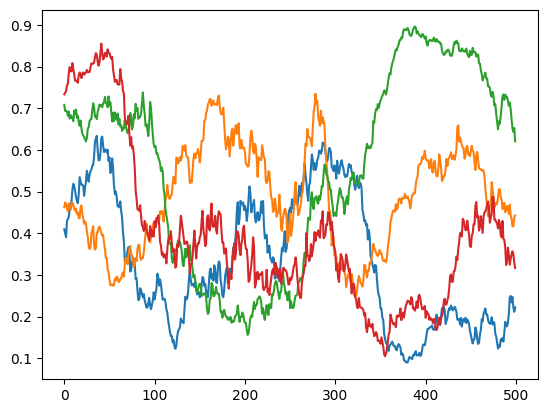

In [10]:
plt.plot(latent_train[:500,0:4].numpy())
plt.show()

In [11]:
lstm_enc = lstm_latent_3(dim_latent = dim_latent)

if torch.cuda.is_available():
    lstm_enc.to("cuda")  

In [12]:
def train_model_lstm(model_enc,epochs, training_dataloader,  
                autograd, enc_loc,  trainloss_loc, valloss_loc,     
                mse_multp = 1.0, return_model = False):
   
    model_enc.train()

    optimiser = autograd(itertools.chain(model_enc.parameters()), lr=0.0001)

    train_loss = []
    val_loss = []

    val_loss_check = 1e10

    train_num = sliding_window - fwd_pred_days

    t0 = time.time()

    print('====Training start====')
    for epoch in range(epochs):
        
        total_mseloss = 0.0

        total_val_loss, total_train_loss = 0.0, 0.0
        
        val_loss_mse = 0.0

        for batch_idx, data in enumerate(training_dataloader):
            # prepare input data
            img = data.to("cuda")
            
            #img = img*mask_tensor[:img.shape[0],...]
            output_en = model_enc(img[:,:train_num,:] , device = 'cuda')
            
            loss_mse = mse_loss(output_en.permute(1,0,2), img[:,1:train_num+1,:])

            loss = (mse_multp * loss_mse)
            
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            # Track this epoch's loss
            total_mseloss += loss_mse.item() * img.shape[0] / latent_train.shape[0]
            total_train_loss += (loss_mse.item()) * img.shape[0] / latent_train.shape[0]

        train_loss.append([total_mseloss, total_train_loss])

        t1 = time.time()

        model_enc.eval()
        with torch.no_grad():
            output_en_val = lstm_enc(img[:,:train_num,:], future = fwd_pred_days, device = 'cuda')
            val_loss_mse += mse_loss(output_en_val.permute(1,0,2)[:,-fwd_pred_days:,:], img[:,-fwd_pred_days:,:]).item()* img.shape[0]*fwd_pred_days / latent_train.shape[0]
            total_val_loss += mse_loss(output_en_val.permute(1,0,2)[:,-fwd_pred_days:,:], img[:,-fwd_pred_days:,:]).item()* img.shape[0]*fwd_pred_days / latent_train.shape[0]
        val_loss.append([val_loss_mse, total_val_loss])

        model_enc.train()
        t2 = time.time()

        #check val error and save model
        if epoch > 0:
            if total_val_loss < val_loss_check:
                torch.save(model_enc, '../' + enc_loc +'intertrain/lstm_' + window_var +  '_' +str(dim_latent)+'_'+ str(epoch) +'_optimal_' + time.strftime("%Y%m%d"))

                if os.path.exists('../' + enc_loc +'intertrain/intertrain_model_log.txt') == False:
                    open('../' + enc_loc +'intertrain/intertrain_model_log.txt', "w").close
                    
                with open('../' + enc_loc +'intertrain/intertrain_model_log.txt', "a") as text_file:
                    text_file.write('====> Epoch: {}, Train time: {:.4f}, Val time: {:.4f} \n'.format(epoch, t1-t0, t2-t1))
                    text_file.write('====> Epoch: {} Total loss: {:.4f} MSE Loss: {:.4f} Val loss: {:.4f} \n'.format(epoch, total_train_loss, total_mseloss, total_val_loss))
                    text_file.write('../' + enc_loc +'intertrain/lstm_' + window_var +  '_'+str(dim_latent)+'_'+ str(epoch) +'_optimal_' + time.strftime("%Y%m%d") + '\n')
                    text_file.write('\n')
                
                val_loss_check = total_val_loss

        print('====> Epoch: {}, Train time: {:.4f}, Val time: {:.4f}'.format(epoch, t1-t0, t2-t1))
        print('====> Epoch: {} Total loss: {:.4f} MSE Loss: {:.4f} Val loss: {:.4f}'.format(epoch, total_train_loss, total_mseloss, total_val_loss))
    
    print('====Training finish====')

    torch.save(model_enc, '../' + enc_loc +'lstm_' + window_var + '_'+ str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"))

    train_loss_np = np.array(train_loss)
    val_loss_np = np.array(val_loss)

    with open('../' + trainloss_loc  + window_var +  '_'+  str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(train_loss_np, output)

    with open('../' + valloss_loc   + window_var +  '_'+  str(dim_latent)+'_'+ str(epochs) +'_' + time.strftime("%Y%m%d-%H%M%S"), 'wb') as output:
        pickle.dump(val_loss_np, output)

    if return_model:
        return model_enc, train_loss , val_loss

In [13]:
if run_training:

    enc, trainloss,valloss = train_model_lstm(
        model_enc = lstm_enc,
        epochs = epochs, 
        training_dataloader = train_loader_sic, 
        autograd = optim.AdamW, 
        enc_loc = 'outputs/final/',
        trainloss_loc = 'outputs/final/lstm_train_loss_', 
        valloss_loc = 'outputs/final/lstm_val_loss_' , 
        mse_multp = 1.0,
        return_model = True
    )

====Training start====
====> Epoch: 0, Train time: 5.1675, Val time: 0.1970
====> Epoch: 0 Total loss: 0.1606 MSE Loss: 0.1606 Val loss: 2.1793
====> Epoch: 1, Train time: 16.7620, Val time: 0.3781
====> Epoch: 1 Total loss: 0.1540 MSE Loss: 0.1540 Val loss: 2.0986
====> Epoch: 2, Train time: 24.2247, Val time: 0.1867
====> Epoch: 2 Total loss: 0.1458 MSE Loss: 0.1458 Val loss: 2.0097
====> Epoch: 3, Train time: 34.8853, Val time: 0.4397
====> Epoch: 3 Total loss: 0.1339 MSE Loss: 0.1339 Val loss: 1.8230
====> Epoch: 4, Train time: 43.9554, Val time: 0.3904
====> Epoch: 4 Total loss: 0.1139 MSE Loss: 0.1139 Val loss: 1.5753
====> Epoch: 5, Train time: 53.7850, Val time: 0.3830
====> Epoch: 5 Total loss: 0.0760 MSE Loss: 0.0760 Val loss: 0.8565
====> Epoch: 6, Train time: 63.8210, Val time: 0.4061
====> Epoch: 6 Total loss: 0.0411 MSE Loss: 0.0411 Val loss: 0.8393
====> Epoch: 7, Train time: 73.4862, Val time: 0.3875
====> Epoch: 7 Total loss: 0.0311 MSE Loss: 0.0311 Val loss: 0.3853
==

In [14]:
## load models ###
if load_ext:
    trained_enc  = lstm_latent()
    trained_enc = torch.load(ext_model_enc)
else:
    trained_enc  = lstm_enc

trained_enc.eval()

lstm_latent_3(
  (lstm1): LSTMCell(64, 128)
  (lstm2): LSTMCell(128, 128)
  (lstm3): LSTMCell(128, 256)
  (linear1): Linear(in_features=256, out_features=64, bias=True)
)

In [15]:
history_val = 700

In [16]:
a1 = trained_enc(latent_train[-history_val:][None, :,:].cuda(), device = 'cuda', future =180)

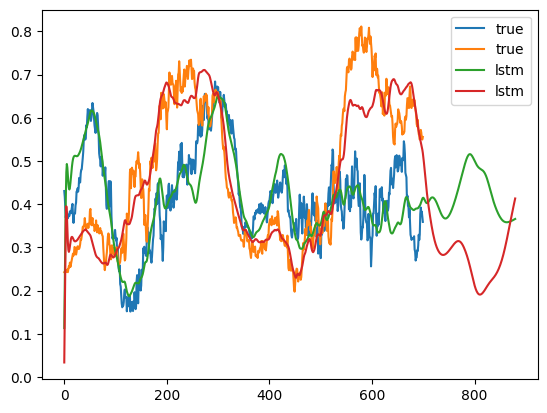

In [17]:
plt.plot(latent_train[-history_val:,30:32].detach(), label = "true")
plt.plot(a1.squeeze().detach().cpu().numpy()[:,30:32], label = "lstm")
plt.legend()
plt.show()

In [18]:
latent_bopdmd = BOPDMD(svd_rank=3, eig_constraints={
                                "stable", # choose Re(lambda)<0
                                "conjugate_pairs", # force complex conjugate pairs
                                })

t_delay_fwd = [i for i in range(latent_train[-history_val:].shape[0])]

t_fwd = [i +history_val  for i in range(180)]

In [19]:
latent_bopdmd.fit((latent_train[-history_val:].detach().numpy().T),t_delay_fwd)

bopdmd_recon = latent_bopdmd.reconstructed_data.T

bopdmd_fwd = latent_bopdmd.forecast(t_fwd).T

bopdmd_all = np.concatenate((bopdmd_recon,bopdmd_fwd))

c:\ProgramData\miniconda3\envs\autoenc1\Lib\site-packages\pydmd\bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


In [20]:
latent_idx = 0

latent_subset = np.concatenate((latent_train[-history_val:,:], latent_test[:180,:].numpy()))


plt.plot(latent_subset[:,latent_idx], label = "true")
plt.plot(a1.squeeze().detach().cpu().numpy()[:,latent_idx], label = 'lstm')
plt.plot(bopdmd_all[:,latent_idx], label = 'bopdmd')
#plt.plot((0.2*bopdmd_all[:,latent_idx]+ 0.8*a1.squeeze().detach().cpu().numpy()[:,latent_idx])/1, label = 'bopdmd +lstm avg')
plt.axvline(x=800, color='black', linestyle='--')
plt.legend()
plt.show()

NameError: name 'latent_test' is not defined

In [ ]:
from IPython.display import display
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Number of rows and columns
rows, cols = 1, 1

# Generate example data sets
num_sets = 64  # Number of different sets of 8x8 grids
x = np.linspace(0, history_val+180, history_val+180)
#x_fwd = np.linspace(731, 730*2, 730)

#SVD_RANK, y1_sets, y2_sets, y3_sets = dmd_latents[4]

def plot_slider(set_index):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5))


    ax = axes
    ax.plot(x, latent_subset[:,set_index], label='True Latent')
    ax.plot(x, a1.squeeze().detach().cpu().numpy()[:,set_index], label = 'lstm')
    ax.plot(x, bopdmd_all[:,set_index], label = 'bopdmd')

    #ax.set_title(f'Set {set_index + 1} - Chart {i * cols + j + 1}')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.legend(loc = 'best' ,prop={'size': 10})


    # ax1 = axes[1]
    # ax1.plot(x_fwd, y4, label='True Latent forward')
    # ax1.plot(x_fwd, y3, label='BOP DMD Forecast, SVD rank = '+ str(SVD_RANK))
    # #ax.set_title(f'Set {set_index + 1} - Chart {i * cols + j + 1}')
    # ax1.set_xlabel('X-axis')
    # ax1.set_ylabel('Y-axis')
    # ax1.legend(loc = 'upper left' ,prop={'size': 8})

    ax.set_ylim(0, 1)
    # ax1.set_ylim(-15, 15)

    plt.axvline(x=800, color='black', linestyle='--')
    plt.tight_layout()
    plt.show()

# Create an interactive slider
interact(plot_slider, set_index=widgets.IntSlider(min=0, max=num_sets - 1, step=1, value=0))


interactive(children=(IntSlider(value=0, description='set_index', max=63), Output()), _dom_classes=('widget-in…

<function __main__.plot_slider(set_index)>

In [ ]:
mse_lstm = ((latent_subset[-180:,:] - a1.squeeze().detach().cpu().numpy()[-180:,:])**2).sum(axis = 0)/180

print(mse_lstm)

mse_lstm_mse = mse_loss(torch.Tensor(latent_subset[-180:,:]),a1.squeeze().detach().cpu()[-180:,:] )

print(mse_lstm_mse)

[0.00246263 0.0251717  0.03700493 0.0065843  0.02317815 0.07502712
 0.02335176 0.06953172 0.00791971 0.01241419 0.00763685 0.11180474
 0.01844157 0.01855859 0.02588301 0.00678855 0.03965373 0.0637173
 0.01665791 0.07662901 0.07563678 0.05990165 0.02801152 0.0139691
 0.01353586 0.05202618 0.08002027 0.02481203 0.02578152 0.01089177
 0.08340804 0.01417379 0.0751802  0.02055906 0.05289878 0.00572826
 0.04062561 0.05078956 0.03812129 0.06551323 0.04221662 0.02004452
 0.01823121 0.0604226  0.00985982 0.02418411 0.03499857 0.01530083
 0.00581472 0.05027231 0.01281043 0.03737252 0.00610513 0.0483738
 0.01105391 0.02187356 0.00311712 0.00987113 0.02499025 0.02122743
 0.03729841 0.0296663  0.02440419 0.02299421]
tensor(0.0327)


In [ ]:
a2 = trained_enc(latent_test[None, :700,:].cuda(), future =30)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [ ]:
plt.plot(latent_test[:,20].detach(), label = "true")
plt.plot(a2.squeeze().detach().cpu().numpy()[:,20], label = "lstm")
plt.axvline(x=700, color='black', linestyle='--')
plt.legend()
plt.show()